In [2]:
%load_ext autoreload
%autoreload 2
from data import *
from visualisation2 import *
import numpy as np
# from analysis import *

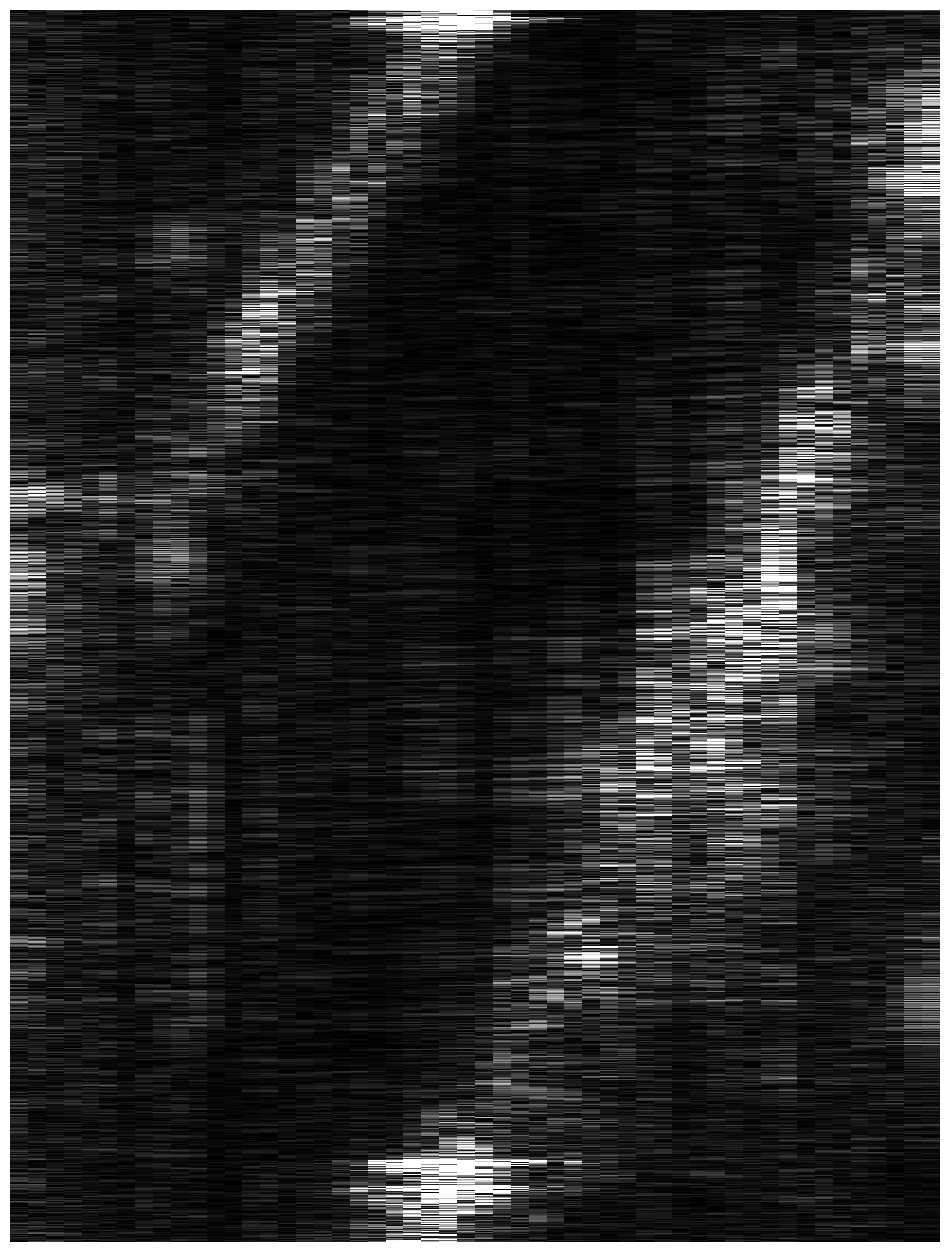

In [3]:
import numpy as np
from visualisation import plot_timeframe
import numpy as np
from data import load_from_file, prepocess

import cv2

filename = "090332.npy"

data = load_from_file(filename)
# plot_timeframe(data)

img = data.to_numpy()

img = prepocess(img)

plot_numpy(img)




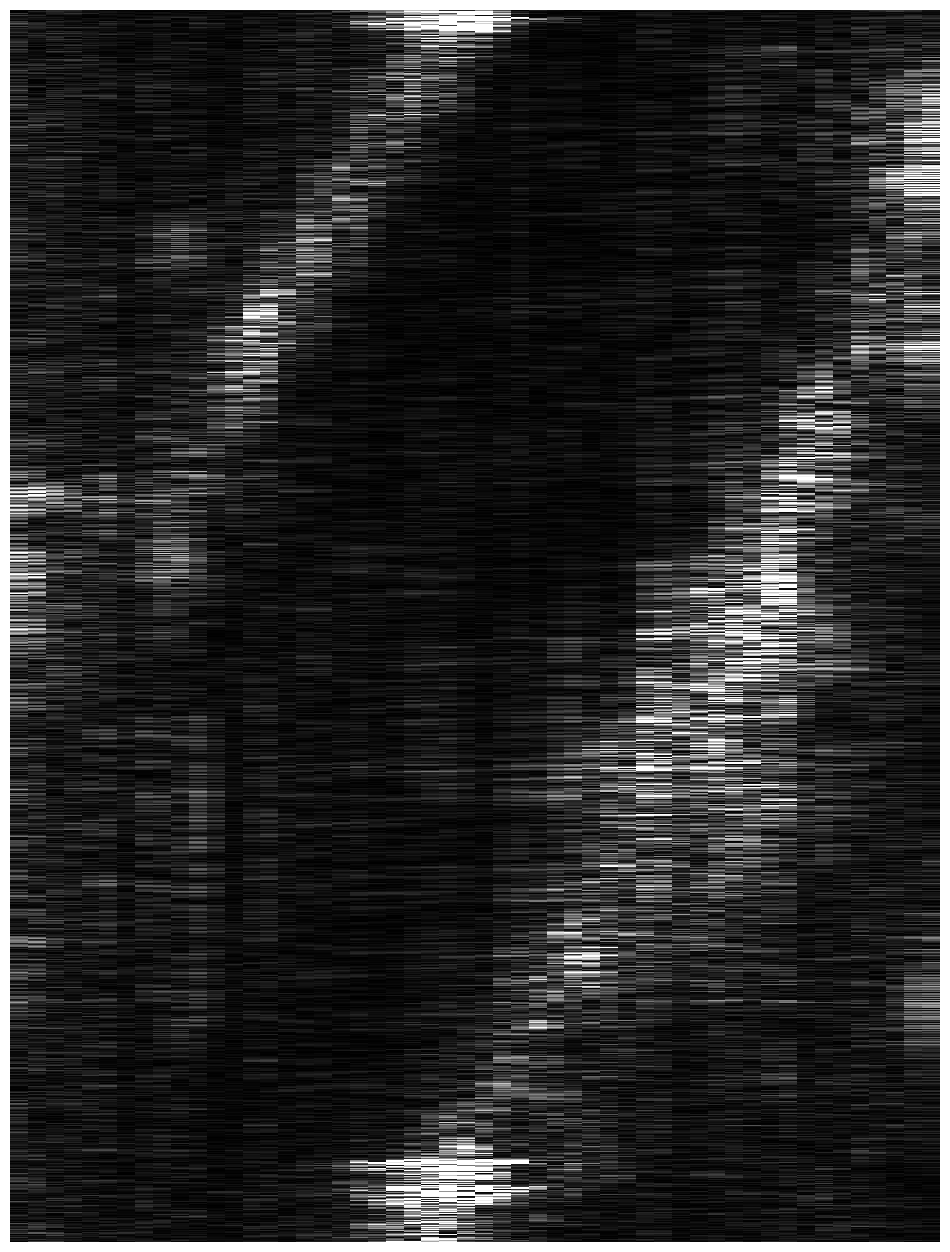

In [4]:
aspect_ratio = 12/16

h,w = img.shape

new_w = int(aspect_ratio * h)

img = cv2.resize(img, (h,new_w), interpolation=cv2.INTER_NEAREST)

plot_numpy(img)

In [5]:
# img = data.to_numpy()
# img = prepocess(img)

# img = cv2.morphologyEx(
#     img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1
# )

# plot_numpy(img)

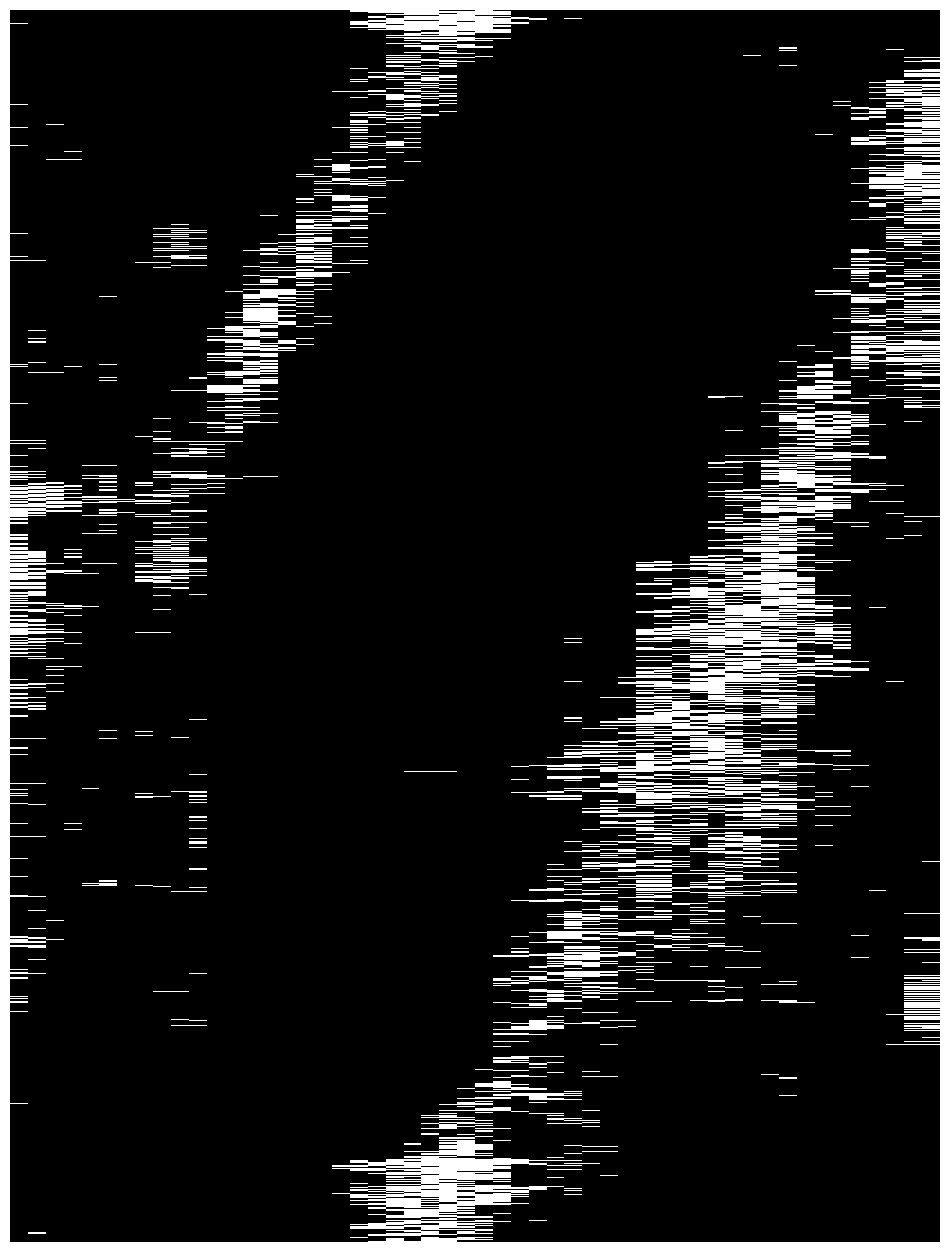

In [6]:
tr, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


plot_numpy(img)

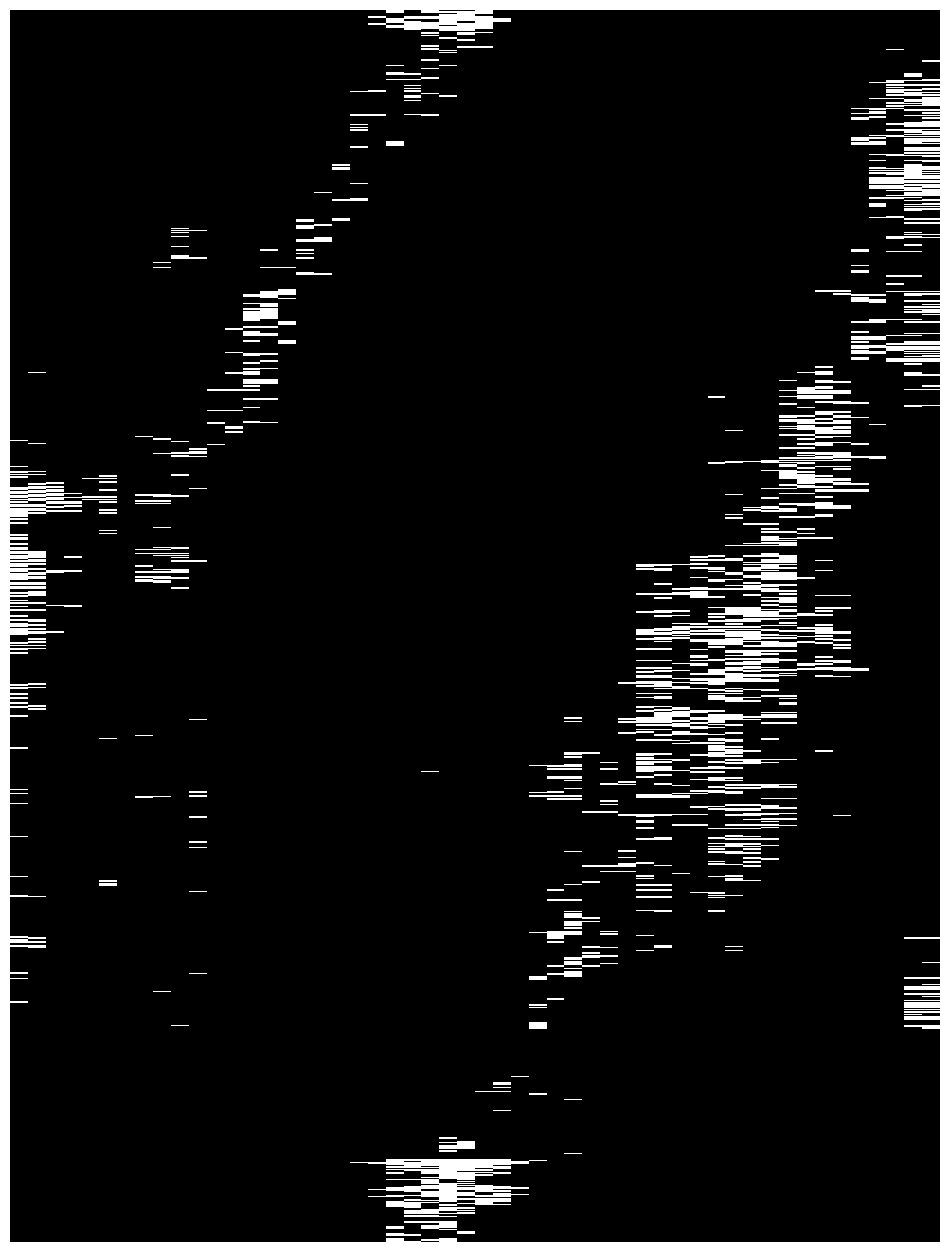

In [7]:
img = cv2.morphologyEx(
    img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations=1
)

plot_numpy(img)

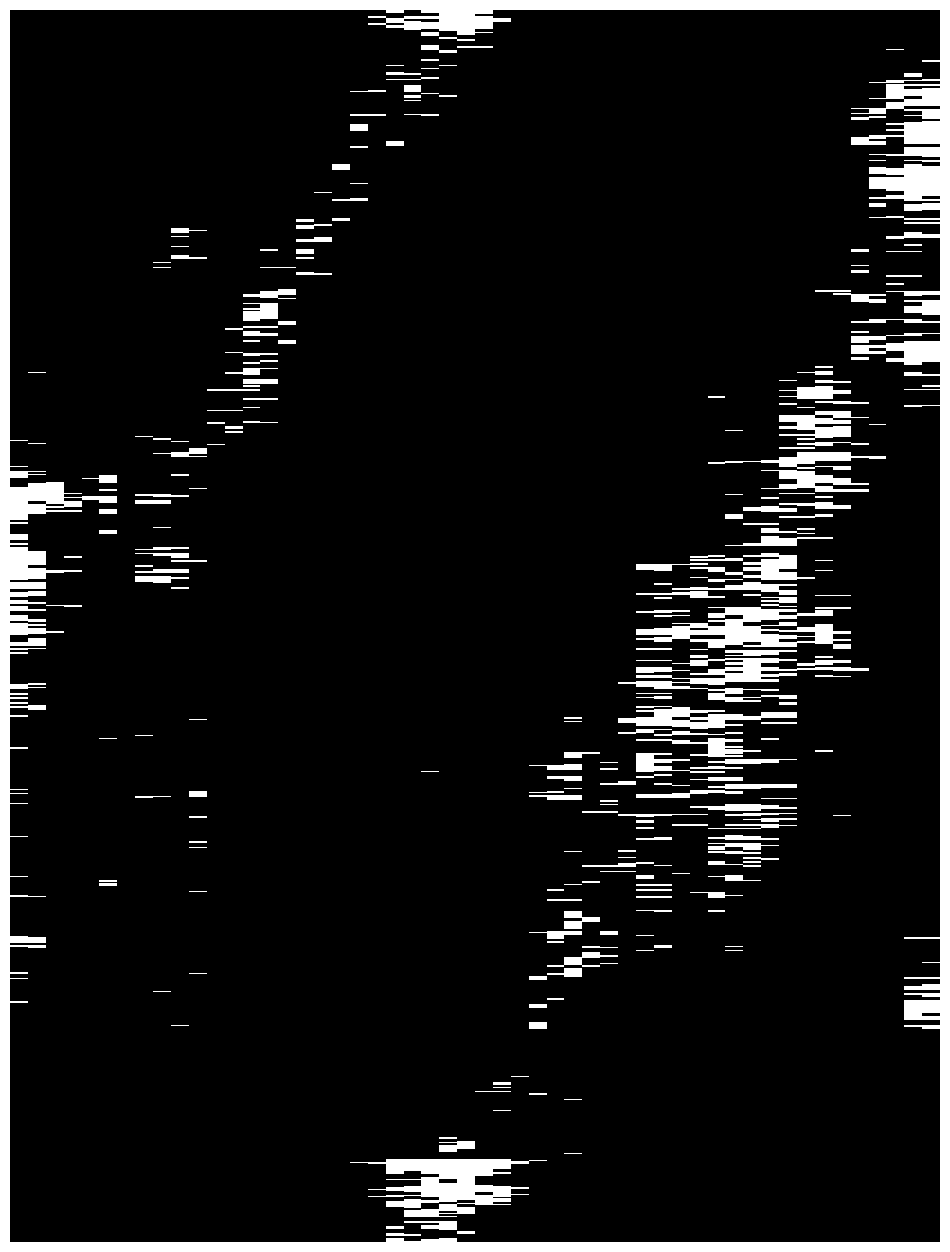

In [8]:
img = cv2.morphologyEx(
    img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)), iterations=1
)

plot_numpy(img)

In [9]:
def generate_colors(num_colors):
    hsv_colors = [(i / num_colors, 1.0, 1.0) for i in range(num_colors)]
    rgb_colors = [plt.cm.hsv(h)[:3] for h, _, _ in hsv_colors]
    rgb_colors = (np.array(rgb_colors) * 255).astype(np.uint8)
    np.random.shuffle(rgb_colors)
    return rgb_colors

In [ ]:
from sklearn.cluster import DBSCAN

img_clusters = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

X = np.nonzero(img)
X = np.vstack(X).T

clustering = DBSCAN(eps=100, min_samples=3).fit(X)

print(clustering.labels_)

no_of_clusters = np.max(clustering.labels_)-1
print(no_of_clusters)

colors = generate_colors(no_of_clusters) 

In [ ]:
no_of_clusters = np.max(clustering.labels_)-1
print("Number of clusters: ", no_of_clusters)
for cluster_id in range(no_of_clusters):
    idx = X[clustering.labels_ == cluster_id, :]
    
    # print(f"Cluster{cluster_id}: {np.sum(idx)} members")
    img_clusters[idx.T[0], idx.T[1],:] = colors[cluster_id]

plot_numpy(img_clusters)

In [ ]:
arr = np.arange(9).reshape((3,3))
idx = np.array([[0,0],[2,1]])
arr[idx.T[0], idx.T[1]] = 69
arr